# ECBM E4040  Assignment 1, Task 2: Multilayer Perceptron (MLP)
This is the second part of the assignment. You will get to know how to build basic fully connected neural network.

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from ecbm4040.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions


In [3]:
from ecbm4040.layer_funcs import affine_forward
from ecbm4040.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Instructions for updating:
Colocations handled automatically by placer.
Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


In [4]:
from ecbm4040.layer_funcs import relu_forward
from ecbm4040.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)
## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


In [5]:
from ecbm4040.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)


## tensorflow gradients
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

In [6]:
## First, let's make a dense layer
from ecbm4040.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients


## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.nn.relu(tf.matmul(x_tf,w_tf) + b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


In [7]:
from ecbm4040.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation


In [8]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

## Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4*L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [9]:
from ecbm4040.train_funcs import train, test

#### Start training

In [10]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

## Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, optim='SGD', verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 3.637612336504567
10000/49000 loss: 2.9341160855975206
15000/49000 loss: 2.3801109409367167
20000/49000 loss: 2.296448309252837
25000/49000 loss: 2.262674504695983
30000/49000 loss: 2.34748024709221
35000/49000 loss: 2.2375829465835553
40000/49000 loss: 2.1553565470933163
45000/49000 loss: 2.11073707467351
epoch 1: valid acc = 0.231, new learning rate = 0.000475
5000/49000 loss: 2.1039330391879743
10000/49000 loss: 2.0978574744667298
15000/49000 loss: 2.0373104943136138
20000/49000 loss: 2.0607036051862377
25000/49000 loss: 2.053951125861936
30000/49000 loss: 1.9944481797060483
35000/49000 loss: 1.9578948213160865
40000/49000 loss: 2.0492464374607593
45000/49000 loss: 1.9799721799744292
epoch 2: valid acc = 0.275, new learning rate = 0.00045125
5000/49000 loss: 1.926303716966745
10000/49000 loss: 1.978989389197037
15000/49000 loss: 1.9299959549989656
20000/49000 loss: 1.914404542453651
25000/49000 loss: 1.9096415041569934
30000/49000 

0.4367

Training and validation accuracy history of each epoch

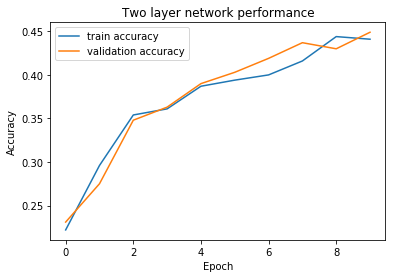

In [11]:
# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Two layer network performance")
plt.savefig("images/twolayernetwork.png")
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [12]:
from ecbm4040.display_funcs import visualize_pics

num of feature vectors: 100


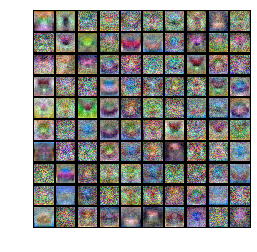

In [13]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Get test accuracy greater than 50%


In [14]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

model = TwoLayerNet(input_dim=3072, hidden_dim=200, num_classes=10, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 100
lr = 5e-4
verbose = True

train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, optim='SGD', verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 490
1000/49000 loss: 8.392201887513732
2000/49000 loss: 3.062990049386947
3000/49000 loss: 2.538074220418677
4000/49000 loss: 2.430278394946818
5000/49000 loss: 2.2725126232298836
6000/49000 loss: 2.1938538393065397
7000/49000 loss: 2.4297153266506246
8000/49000 loss: 2.183618082587659
9000/49000 loss: 2.1850683142246856
10000/49000 loss: 2.1281889931664764
11000/49000 loss: 2.0980723246703903
12000/49000 loss: 2.080537599818109
13000/49000 loss: 2.0132841967092543
14000/49000 loss: 1.9976136096476012
15000/49000 loss: 1.9654599778315174
16000/49000 loss: 1.966557504414489
17000/49000 loss: 1.921408555629644
18000/49000 loss: 1.875305178618291
19000/49000 loss: 1.9243553074360245
20000/49000 loss: 1.9797983914831117
21000/49000 loss: 1.920253453497122
22000/49000 loss: 1.8163848609332633
23000/49000 loss: 1.9910539476861573
24000/49000 loss: 1.9150258314817734
25000/49000 loss: 1.9111029027496564
26000/49000 loss: 1.8541202400362522
27000/49000 loss: 1.9

22000/49000 loss: 1.2872937922611583
23000/49000 loss: 1.4797863480430467
24000/49000 loss: 1.3885713001078037
25000/49000 loss: 1.342836996356702
26000/49000 loss: 1.4686383246903851
27000/49000 loss: 1.288185958061758
28000/49000 loss: 1.2644609966072227
29000/49000 loss: 1.3149493278459772
30000/49000 loss: 1.4725036610185054
31000/49000 loss: 1.4033406183220996
32000/49000 loss: 1.530095945880285
33000/49000 loss: 1.4748365142284479
34000/49000 loss: 1.3340771119843116
35000/49000 loss: 1.4305911377572458
36000/49000 loss: 1.4810126698471002
37000/49000 loss: 1.3279280465634904
38000/49000 loss: 1.347744238223981
39000/49000 loss: 1.366075892522721
40000/49000 loss: 1.421364234099439
41000/49000 loss: 1.4910291845199661
42000/49000 loss: 1.577761042269561
43000/49000 loss: 1.319361562176388
44000/49000 loss: 1.2980989856614293
45000/49000 loss: 1.3890306719061198
46000/49000 loss: 1.5269503581829986
47000/49000 loss: 1.3169396160282059
48000/49000 loss: 1.4052771838359652
49000/490

43000/49000 loss: 1.100126607222086
44000/49000 loss: 1.107364083553332
45000/49000 loss: 1.147925969582075
46000/49000 loss: 1.2582302556979392
47000/49000 loss: 1.121705449342872
48000/49000 loss: 1.2105592226531179
49000/49000 loss: 1.41211256447538
epoch 9: valid acc = 0.515, new learning rate = 0.0003151247048623045
1000/49000 loss: 1.0841725347592754
2000/49000 loss: 1.2812033543469759
3000/49000 loss: 1.1327447245158724
4000/49000 loss: 1.3533239991778807
5000/49000 loss: 1.3263781617366275
6000/49000 loss: 1.0271081844967511
7000/49000 loss: 1.3522400519859896
8000/49000 loss: 1.146204338036201
9000/49000 loss: 1.3032990759147578
10000/49000 loss: 1.1635482521251044
11000/49000 loss: 1.2618469785521154
12000/49000 loss: 1.2087962772617769
13000/49000 loss: 1.1876875429456306
14000/49000 loss: 1.2108427609436196
15000/49000 loss: 1.0103156488919343
16000/49000 loss: 1.343119300288974
17000/49000 loss: 0.9498548617053352
18000/49000 loss: 1.1710650036833463
19000/49000 loss: 1.14

0.5105

Best result, including accuracy and weights of the first layer

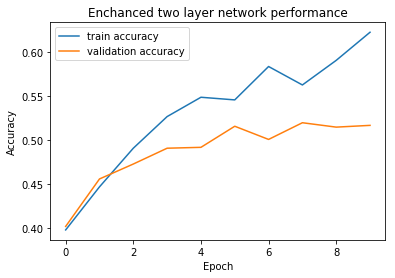

In [15]:
## plot training and validation accuracy
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Enchanced two layer network performance")
plt.savefig("images/twolayernetwork_enchanced.png")
plt.show()

num of feature vectors: 200


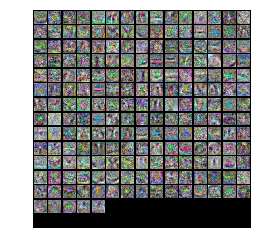

In [16]:
## Visualize weights
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Save your best model in a dictionary 

In [17]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

## Part 3: Multilayer Net 


In [18]:
from ecbm4040.classifiers.mlp import MLP

## Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
epoch 1: valid acc = 0.119, new learning rate = 0.0095
epoch 2: valid acc = 0.16, new learning rate = 0.009025
epoch 3: valid acc = 0.242, new learning rate = 0.00857375
epoch 4: valid acc = 0.272, new learning rate = 0.0081450625
epoch 5: valid acc = 0.324, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.394, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.431, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.433, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.444, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.466, new learning rate = 0.005987369392383786
test acc: 0.4515


0.4515

## Part 4: Tensorflow MLP


In [19]:
## Demo: Two-layer net in tensorflow.
hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.22200000286102295
epoch 2: valid acc = 0.31200000643730164
epoch 3: valid acc = 0.2879999876022339
epoch 4: valid acc = 0.3400000035762787
epoch 5: valid acc = 0.33500000834465027
epoch 6: valid acc = 0.382999986410141
epoch 7: valid acc = 0.39399999380111694
epoch 8: valid acc = 0.39800000190734863
epoch 9: valid acc = 0.39899998903274536
epoch 10: valid acc = 0.4180000126361847
test acc = 0.4180000126361847


Create MLP in tensorflow

In [20]:

hidden_dim = 100
reg_tf = tf.constant(0.01)

weights = {
    'w1': tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32')),
    'w2': tf.Variable(1e-2*np.random.rand(hidden_dim, hidden_dim).astype('float32')),
    'w3': tf.Variable(1e-2*np.random.rand(hidden_dim, hidden_dim).astype('float32')),
    'w4': tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32')),
    'b1': tf.Variable(np.zeros((hidden_dim,)).astype('float32')),
    'b2': tf.Variable(np.zeros((hidden_dim,)).astype('float32')),
    'b3': tf.Variable(np.zeros((hidden_dim,)).astype('float32')),
    'b4': tf.Variable(np.zeros((10,)).astype('float32'))
}


x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

h1_tf = tf.nn.relu(tf.matmul(x_tf, weights['w1']) + weights['b1'])
h2_tf = tf.nn.relu(tf.matmul(h1_tf, weights['w2']) + weights['b2'])
h3_tf = tf.nn.relu(tf.matmul(h2_tf, weights['w3']) + weights['b3'])
h4_tf = tf.matmul(h1_tf, weights['w4']) + weights['b4']

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h4_tf, labels=tf.one_hot(y_tf,10))

L2_loss = 0.0
for i in range(1,5):
    w_iter = 'w'+str(i)
    L2_loss += tf.nn.l2_loss(weights[w_iter])
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h4_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.1899999976158142
epoch 2: valid acc = 0.2590000033378601
epoch 3: valid acc = 0.3050000071525574
epoch 4: valid acc = 0.3009999990463257
epoch 5: valid acc = 0.35100001096725464
epoch 6: valid acc = 0.3659999966621399
epoch 7: valid acc = 0.37299999594688416
epoch 8: valid acc = 0.40400001406669617
epoch 9: valid acc = 0.4129999876022339
epoch 10: valid acc = 0.4180000126361847
test acc = 0.4180000126361847
